Populating the interactive namespace from numpy and matplotlib


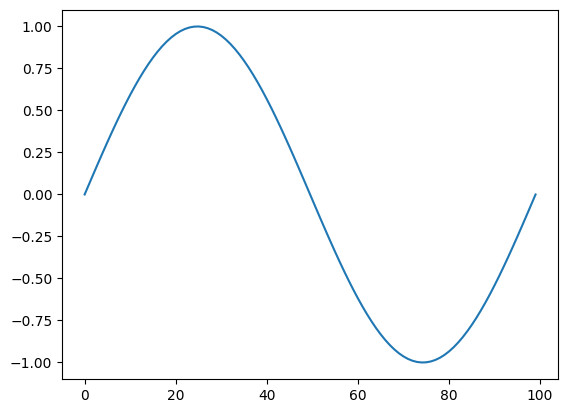

In [1]:
%pylab inline 
import matplotlib.pyplot as plt 
import numpy as np
plt.plot(np.sin(np.linspace(0,2*np.pi, 100)))

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from basic_tools import *
# 有时候下载数据集会报错，加下边这两行就可以了
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
def get_data_loaders(train_batch_size, test_batch_size, transform_train=None, transform_test=None):
    # 图像变换,预处理操作，
    if transform_train == None:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    if transform_test == None:
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    train_data = torchvision.datasets.CIFAR100(
        root="./data", train=True, download=False, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        train_data, batch_size=train_batch_size, shuffle=True, num_workers=0)
    test_data = torchvision.datasets.CIFAR100(
        root="./data", train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)

    return trainloader, testloader


In [4]:
batch_size = 512
trainloader, testloader = get_data_loaders(128, 128)


In [5]:
images, labels = next(iter(trainloader))
print(images.shape, labels.shape)


torch.Size([128, 3, 32, 32]) torch.Size([128])


In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


In [7]:

class BasicBlock_v2(nn.Module):
    # 按照何凯明的做法优化下，然后又给每一个残差块加了个dropout,https://blog.csdn.net/u013817537/article/details/116500611
    # dropout试了下，负优化，删了
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock_v2, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        # out=self.dropout(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity

        return out


In [8]:

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.5) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class WeightedPermuteMLP(nn.Module):
    def __init__(self, n, h, w, c, proj_drop=0.3) -> None:
        super().__init__()
        self.n = n
        # self.norm1 = nn.LayerNorm(c)
        self.mlp_c = nn.Linear(c, c)
        self.mlp_h = nn.Linear(c, c)
        self.mlp_w = nn.Linear(c, c)
        self.reweight = Mlp(c, c // 4, c * 3)
        self.proj = nn.Linear(c, c)
        self.proj_drop = nn.Dropout(proj_drop)
        # self.norm2 = nn.LayerNorm(c)

    def forward(self, x):
        pre = x
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        S = C // self.n

        # x = self.norm1(x)

        h = x.reshape(B, H, W, self.n, S).permute(
            0, 3, 2, 1, 4).reshape(B, self.n, W, H * S)
        # print(h.shape)
        h = self.mlp_h(h).reshape(B, self.n, W, H, S).permute(
            0, 3, 2, 1, 4).reshape(B, H, W, C)

        w = x.reshape(B, H, W, self.n, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, self.n, W * S)
        # print(w.shape)
        w = self.mlp_w(w).reshape(B, H, self.n, W, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, W, C)

        # print(x.shape)
        c = self.mlp_c(x)

        a = (h + w + c).permute(0, 3, 1, 2).flatten(2).mean(2)
        a = self.reweight(a).reshape(B, C, 3).permute(
            2, 0, 1).softmax(dim=0).unsqueeze(2).unsqueeze(2)

        # print(h.shape, w.shape, c.shape, a.shape)
        # x = (h + w + c) / 3
        x = h * a[0] + w * a[1] + c * a[2]

        x = self.proj(x)
        x = self.proj_drop(x)

        x = x.permute(0, 3, 1, 2)
        x = pre + x
        # x = self.norm2(x)

        return x


In [9]:

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.permute1 = WeightedPermuteMLP(32, 32, 32, 64)
        # self.permute1 = WeightedPermuteMLP(8, 8, 8, 64)
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        # self.permute2 = WeightedPermuteMLP(16, 16, 16, 128)
        # self.permute2 = WeightedPermuteMLP(4, 4, 4, 128)
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        # self.permute3 = WeightedPermuteMLP(8, 8, 8, 256)
        # self.permute3 = WeightedPermuteMLP(2, 2, 2, 256)
        self.layer4 = self.make_layer(block, 512, layers[3], 2)
        # self.permute4 = WeightedPermuteMLP(4, 4, 4, 512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        # print(out.shape)
        out = self.permute1(out)
        out = self.layer2(out)
        # print(out.shape)
        # out = self.permute2(out)
        out = self.layer3(out)
        # print(out.shape)
        # out = self.permute3(out)
        out = self.layer4(out)
        # print(out.shape)
        # out = self.permute4(out)
        out = self.avg_pool(out)
        # print(out.shape)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [10]:
net = ResNet(BasicBlock_v2, [2, 2, 2, 2])
image, label = next(iter(trainloader))
net(image)
# print(net)


tensor([[-0.3745, -0.0960, -0.2748,  ...,  0.2330, -0.2125, -0.5036],
        [-0.0959, -0.7017, -0.1504,  ...,  0.0584, -0.4263, -0.3330],
        [ 0.2567, -1.2349,  0.3184,  ...,  0.5639, -0.8290, -0.5962],
        ...,
        [-0.5621, -0.7851, -0.2667,  ...,  0.2351, -0.7218, -0.2558],
        [-0.0369, -0.5189, -0.4480,  ..., -0.3520, -0.7988, -0.3128],
        [-0.3519, -0.1471, -0.1192,  ...,  0.2200,  0.0962, -0.0449]],
       grad_fn=<AddmmBackward0>)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
learning_rate = 0.05
momentum = 0.9
weight_decay = 0.0001
epochs = 200
model = ResNet(BasicBlock_v2, [2, 2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model.parameters(
), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


cuda


In [12]:
# 训练之
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss, train_acc, train_top5_acc = train(
        model, trainloader, criterion, optimizer, device)
    test_loss, test_acc, test_top5_acc = test(
        model, testloader, criterion, device)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(
        epoch, train_loss, train_acc, train_top5_acc, test_loss, test_acc, test_top5_acc))
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)



epoch:0,train_loss:3.8073,train_acc:11.3780,train_top5_acc:33.9160,test_loss:3.4114,test_acc:18.9300,test_top5_acc:45.8300
epoch:1,train_loss:3.0885,train_acc:22.6940,train_top5_acc:53.4680,test_loss:3.0162,test_acc:26.2200,test_top5_acc:57.4600
epoch:2,train_loss:2.6454,train_acc:31.3660,train_top5_acc:64.0940,test_loss:2.7167,test_acc:30.5300,test_top5_acc:63.6000
epoch:3,train_loss:2.3212,train_acc:38.3600,train_top5_acc:71.5480,test_loss:2.4045,test_acc:37.5100,test_top5_acc:70.0600
epoch:4,train_loss:2.0694,train_acc:43.9380,train_top5_acc:76.6600,test_loss:2.2795,test_acc:40.5000,test_top5_acc:72.6500
epoch:5,train_loss:1.8629,train_acc:48.4180,train_top5_acc:80.4340,test_loss:2.3117,test_acc:42.9100,test_top5_acc:73.9900
epoch:6,train_loss:1.6999,train_acc:52.1640,train_top5_acc:83.0820,test_loss:1.7998,test_acc:50.9000,test_top5_acc:81.1200
epoch:7,train_loss:1.5675,train_acc:55.7500,train_top5_acc:85.3260,test_loss:1.8459,test_acc:50.7200,test_top5_acc:80.3600
epoch:8,train_lo

PermissionError: [Errno 13] Permission denied: '../train_process'

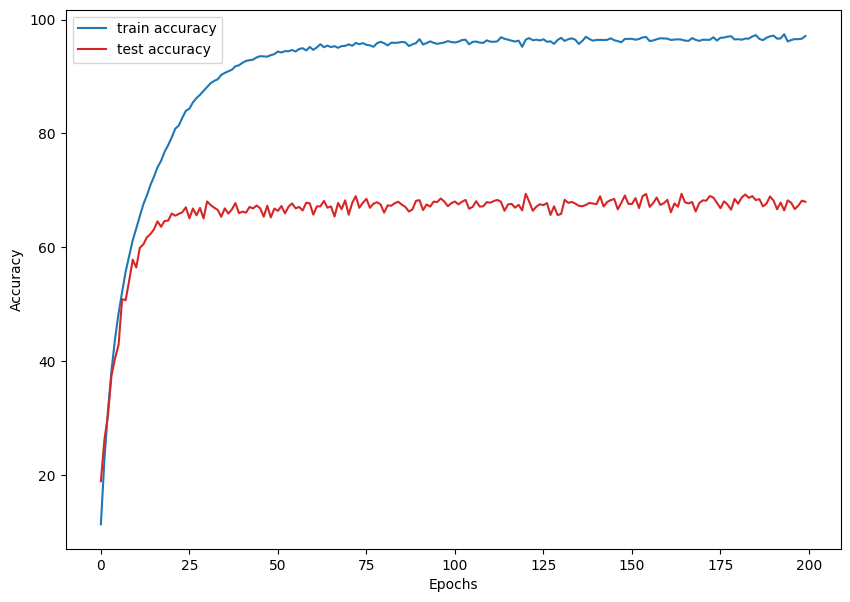

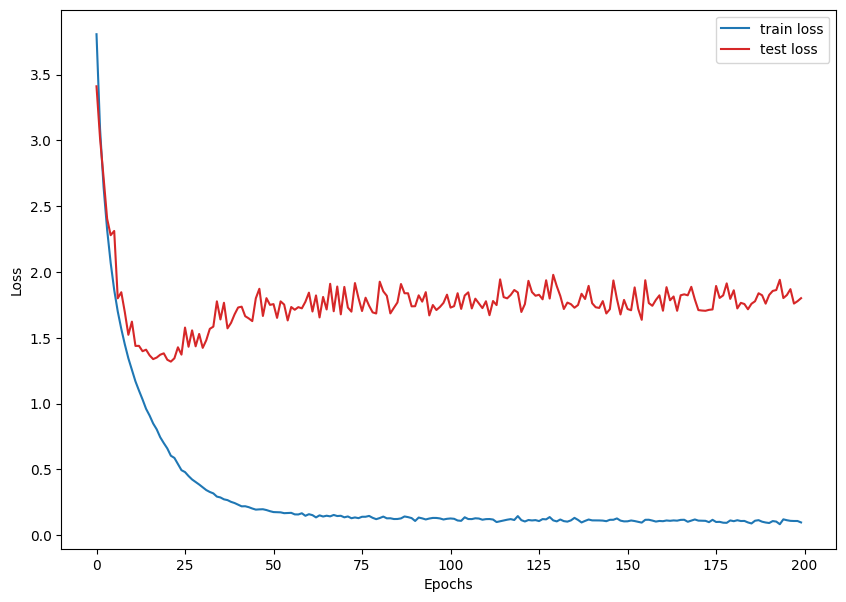

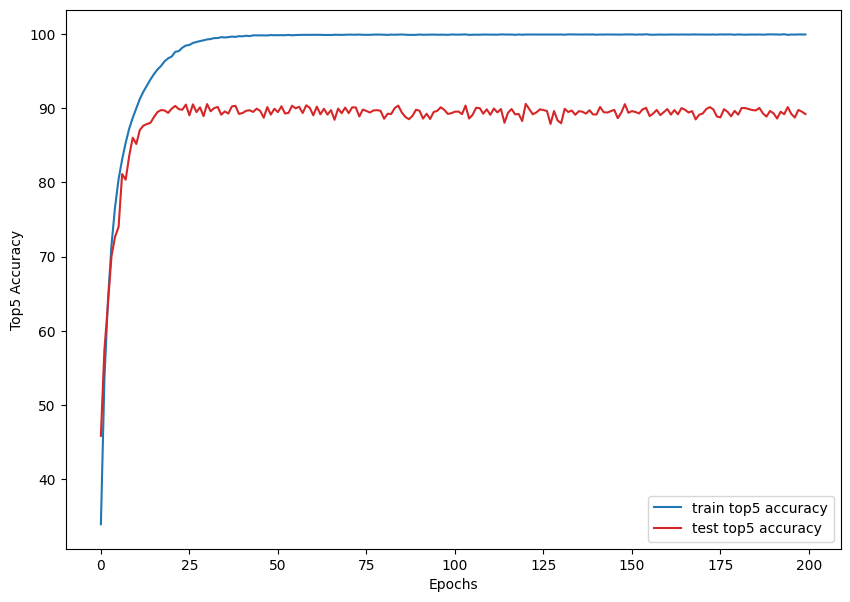

In [15]:
def save_plots(train_acc, test_acc, train_loss, test_loss,train_top5_correct,test_top5_correct,modelname,output_dir='./train_process'):
    """
    Function to save the loss and accuracy plots to disk.
    """
    if modelname==None:
        modelname='unnamed model'
    output_dir=output_dir+'/'+modelname
    # Create directory if it doesn't exist.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color="tab:blue", linestyle="-", label="train accuracy")
    plt.plot(test_acc, color="tab:red", linestyle="-", label="test accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(output_dir, modelname + "_accuracy.png"))

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color="tab:blue", linestyle="-", label="train loss")
    plt.plot(test_loss, color="tab:red", linestyle="-", label="test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(output_dir, modelname + "_loss.png"))

    # Top5 accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_top5_correct, color="tab:blue", linestyle="-", label="train top5 accuracy")
    plt.plot(test_top5_correct, color="tab:red", linestyle="-", label="test top5 accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Top5 Accuracy")
    plt.legend()
    plt.savefig(os.path.join(output_dir, modelname + "_top5_accuracy.png"))
save_plots(train_acca, test_acca, train_lossa, test_lossa, train_top5_acca, test_top5_acca, "resnet18+permuteMLP")